![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest gap-filling
</b>
</span>

---
**Notebook version**: `1` (9 Sep 2023)  
Example notebook for the class `pkgs.gapfilling.randomforest_ts.RandomForestTS` using the time series processing library `diive`.  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  


</br>

---

# **Background**

- Using random forest to gap-fill time series data

</br>

---

# **Setup**

## User settings
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

## Imports
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.dfun.frames import steplagged_variants
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
from diive.core.times.times import include_timestamp_as_cols
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

C:\Users\nopan\AppData\Local\pypoetry\Cache\virtualenvs\diive-wQ6jAUAf-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


This page was last modified on: 2023-09-09 00:28:12
diive version: v0.57.0


### Show docstring for `RandomForestTS`

In [3]:
print(RandomForestTS.__name__)
print(RandomForestTS.__doc__)

RandomForestTS
None


</br>

---

# **Load data**

## Load example data from pickle file

In [24]:
source_df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.050 seconds). Detected time resolution of <30 * Minutes> / 30T 


## Make subset

In [25]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [26]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671446
std,6.085451,7.548653,3.710180,247.531312
min,-38.653390,-23.096000,0.000000,0.000000
25%,-7.840419,-0.800000,0.661000,0.000000
50%,-3.827018,4.600000,1.990568,2.596048
75%,0.606166,10.067000,4.375000,225.677750
max,25.290227,28.713000,32.118000,1197.799920


In [27]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
SD,6.085451
VAR,37.032717
SD/MEAN,-1.587431


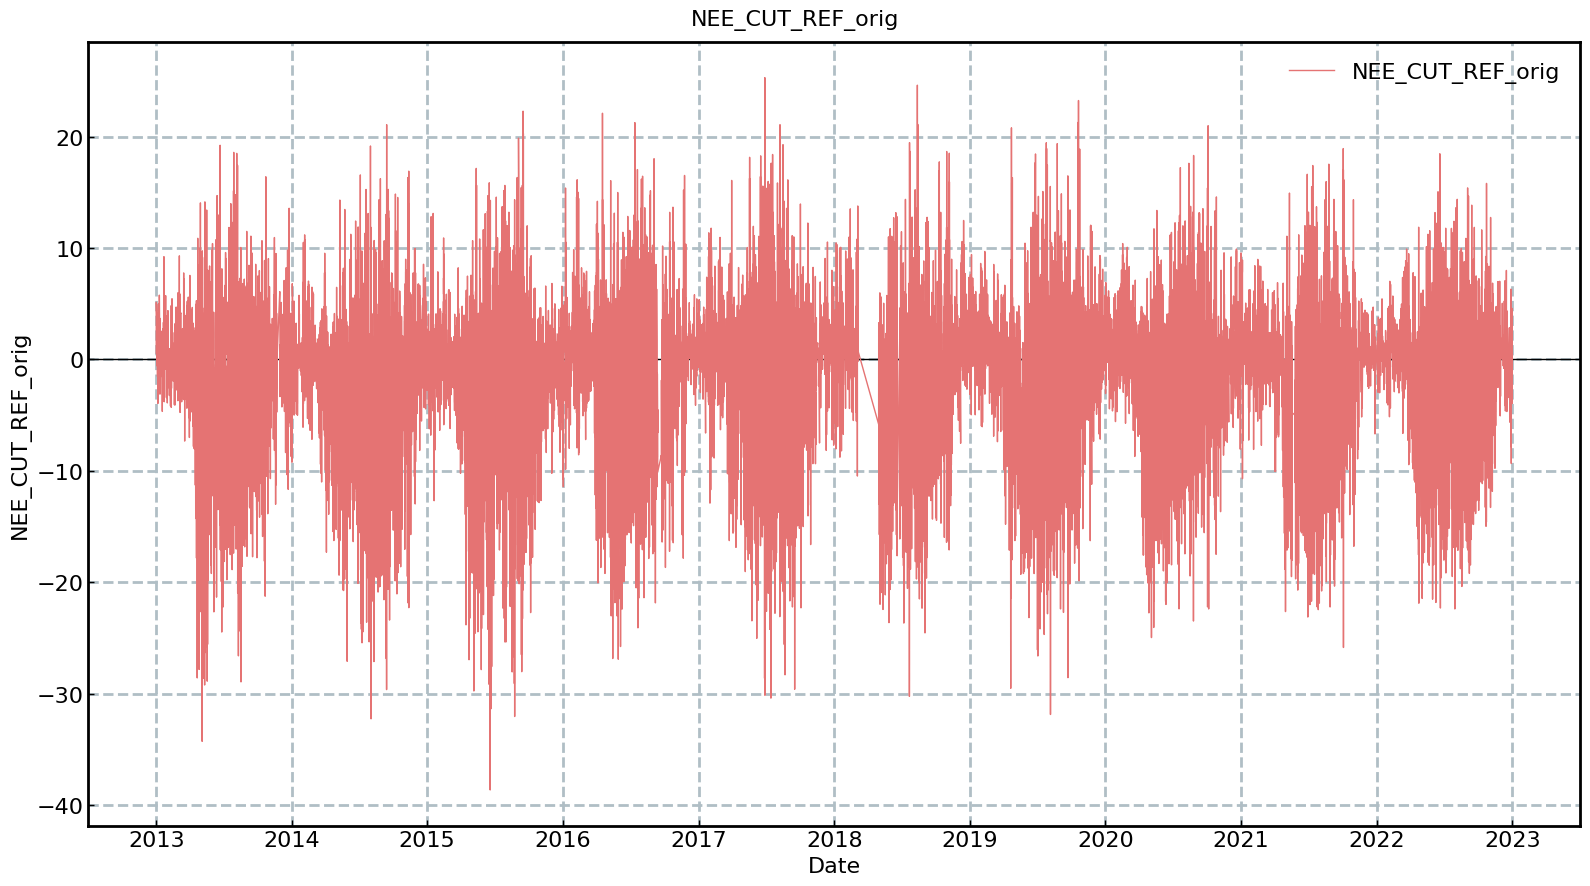

In [28]:
TimeSeries(series=df[TARGET_COL]).plot()

In [29]:
TimeSeries(series=df[TARGET_COL]).plot_interactive()

</br>

</br>

---

# **Add additional features (optional)**

## Add lagged variants

In [30]:
df = steplagged_variants(df=df,
                         stepsize=1,
                         stepmax=1,
                         exclude_cols=[TARGET_COL])

Created step-lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f']
No step-lagged variants for: ['NEE_CUT_REF_orig']


## Include timestamp info as columns

In [31]:
df = include_timestamp_as_cols(df=df, txt="(...)")

Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR'] (...)


In [32]:
df

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f,.Tair_f-1,.VPD_f-1,.Rg_f-1,.YEAR,.SEASON,.MONTH,.WEEK,.DOY,.HOUR
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2013-01-01 00:15:00,NaN,-1.618000,1.339000,0.0,NaN,NaN,NaN,2013,4,1,1,1,0
2013-01-01 00:45:00,NaN,-1.630000,1.337000,0.0,-1.618000,1.339000,0.0,2013,4,1,1,1,0
2013-01-01 01:15:00,NaN,-1.644000,1.335000,0.0,-1.630000,1.337000,0.0,2013,4,1,1,1,1
2013-01-01 01:45:00,0.537565,-1.657000,1.332000,0.0,-1.644000,1.335000,0.0,2013,4,1,1,1,1
2013-01-01 02:15:00,NaN,-0.567000,3.545000,0.0,-1.657000,1.332000,0.0,2013,4,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,NaN,3.463333,2.210036,0.0,3.696667,2.287448,0.0,2022,4,12,52,365,21
2022-12-31 22:15:00,3.517950,5.283333,3.327497,0.0,3.463333,2.210036,0.0,2022,4,12,52,365,22
2022-12-31 22:45:00,NaN,5.536667,3.466505,0.0,5.283333,3.327497,0.0,2022,4,12,52,365,22


</br>

---

# **Gap-filling**

## Initialize

In [33]:
rfts = RandomForestTS(
    input_df=df,
    target_col=TARGET_COL,
    verbose=1,
    n_estimators=99,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5,
    perm_n_repeats=22,
    n_jobs=-1
)

</br>

## Train model

(_trainmodel with random)    Building random forest model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...
Accepted variables: ['.MONTH', '.SEASON', '.WEEK', 'VPD_f', '.YEAR', '.VPD_f-1', '.Rg_f-1', '.HOUR', '.Tair_f-1', 'Tair_f', '.DOY', 'Rg_f']  -->  above permutation importance threshold of -7.773285314906357e-05
Rejected variables: ['.RANDOM']  -->  below permutation importance threshold of -7.773285314906357e-05


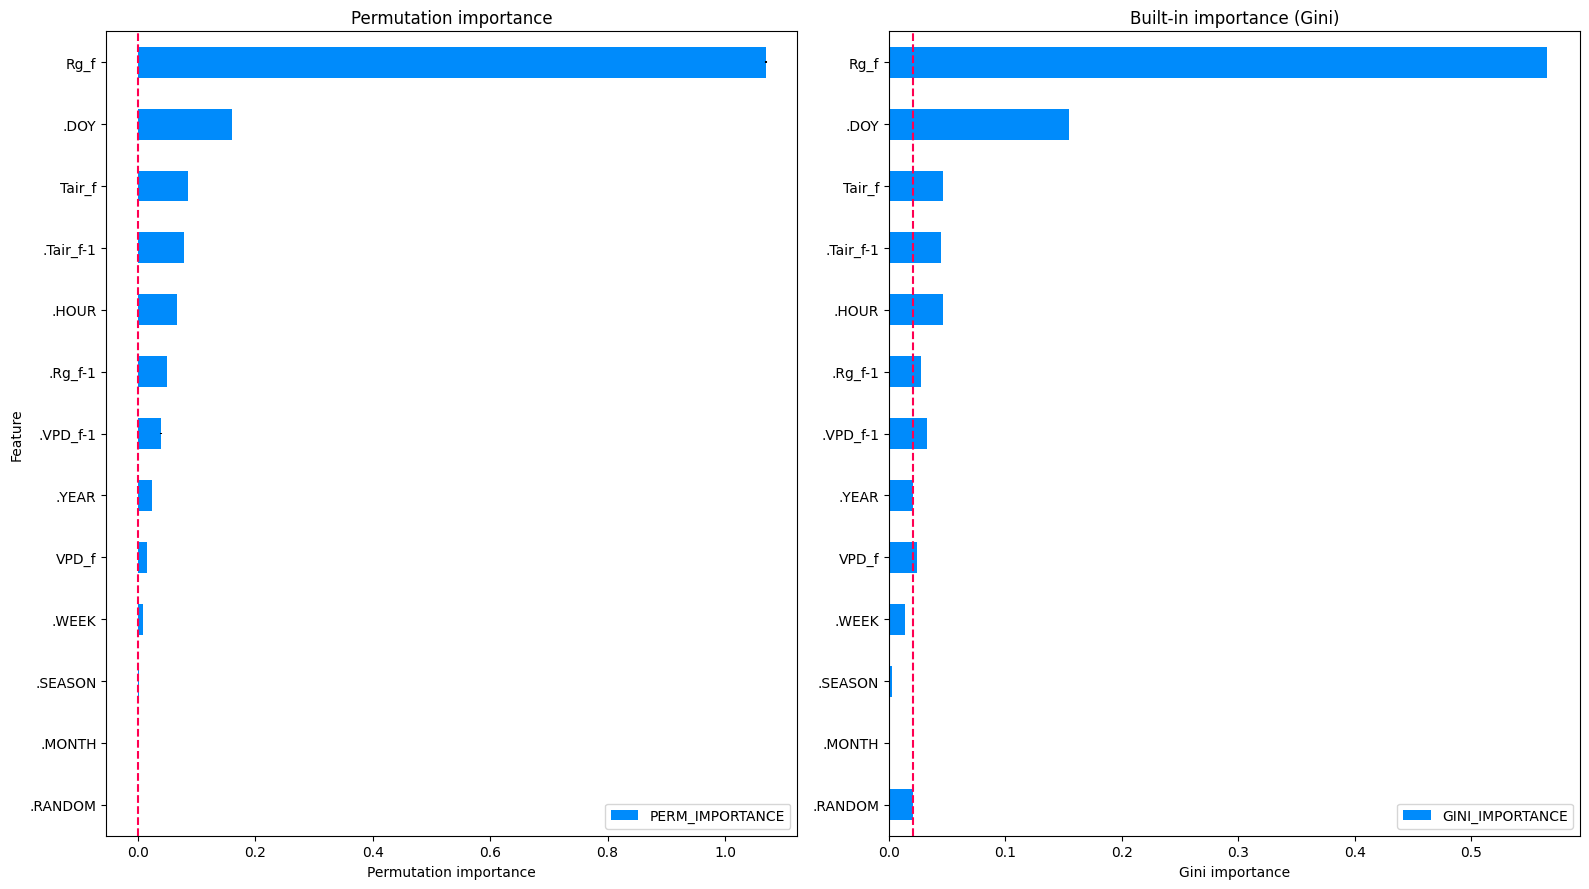

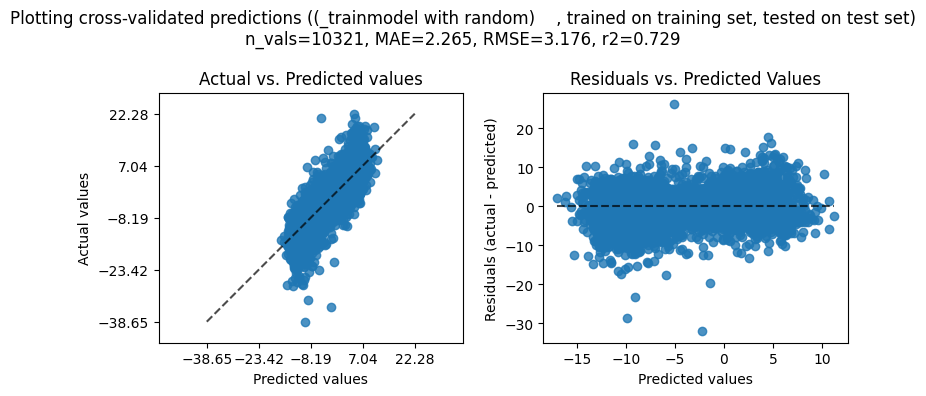

(_trainmodel with random)     MODEL TRAINING & TESTING RESULTS
(_trainmodel with random)       - the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
(_trainmodel with random)       - in total, 41284 observed target values were available for training and testing
(_trainmodel with random)       - the dataset was split into training and test datasets
(_trainmodel with random)           - the training dataset comprised 30963 target values (75.0%)
(_trainmodel with random)           - the test dataset comprised 10321 target values (25.0%)
(_trainmodel with random)    
(_trainmodel with random)       MODEL
(_trainmodel with random)       The model was trained on the training set.
(_trainmodel with random)       - estimator:  RandomForestRegressor(min_samples_leaf=5, min_samples_split=10, n_estimators=99,
                      n_jobs=-1, random_state=42)
(_trainmodel with random)       - parameters:  {'bootstrap': True, 'ccp_

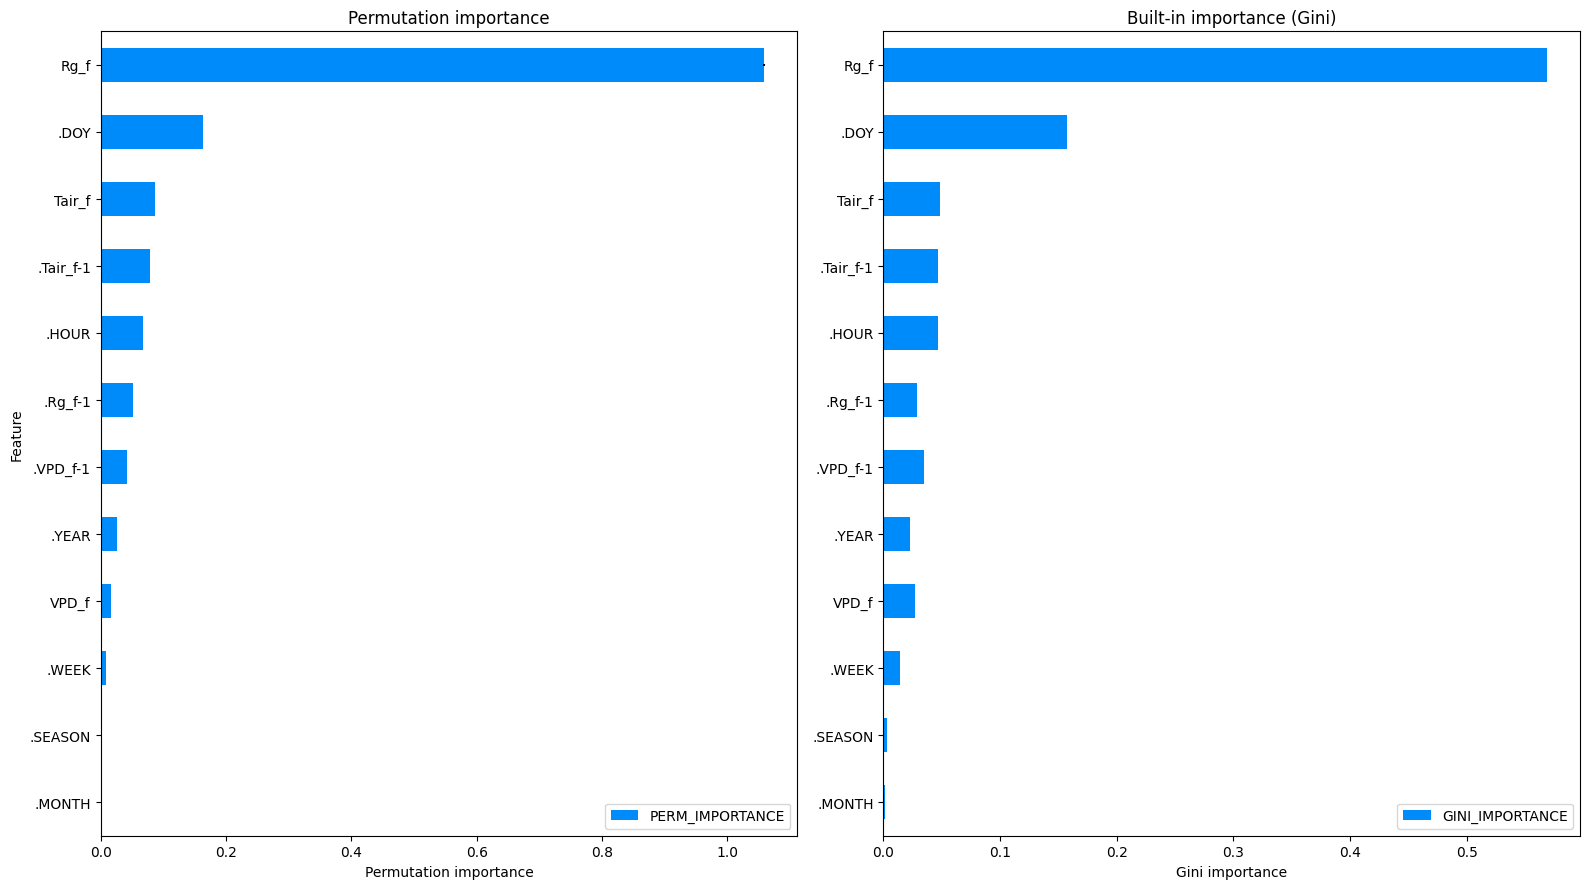

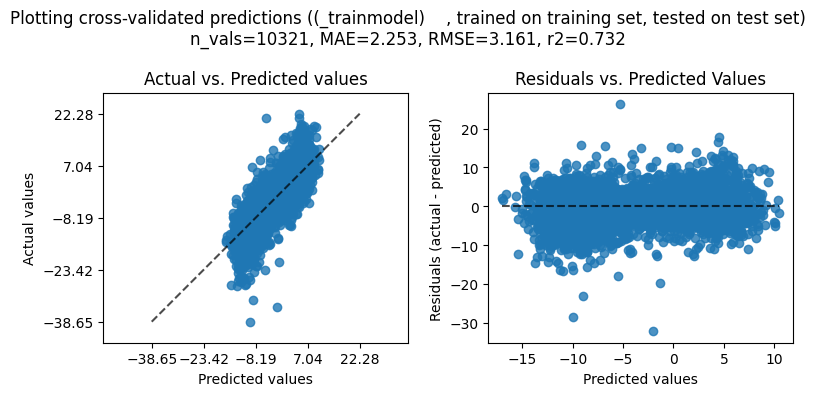

(_trainmodel)     MODEL TRAINING & TESTING RESULTS
(_trainmodel)       - the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
(_trainmodel)       - in total, 41284 observed target values were available for training and testing
(_trainmodel)       - the dataset was split into training and test datasets
(_trainmodel)           - the training dataset comprised 30963 target values (75.0%)
(_trainmodel)           - the test dataset comprised 10321 target values (25.0%)
(_trainmodel)    
(_trainmodel)       MODEL
(_trainmodel)       The model was trained on the training set.
(_trainmodel)       - estimator:  RandomForestRegressor(min_samples_leaf=5, min_samples_split=10, n_estimators=99,
                      n_jobs=-1, random_state=42)
(_trainmodel)       - parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min

In [34]:
rfts.trainmodel(showplot_predictions=True, showplot_importance=True, verbose=1)

</br>

## Apply model to fill gaps

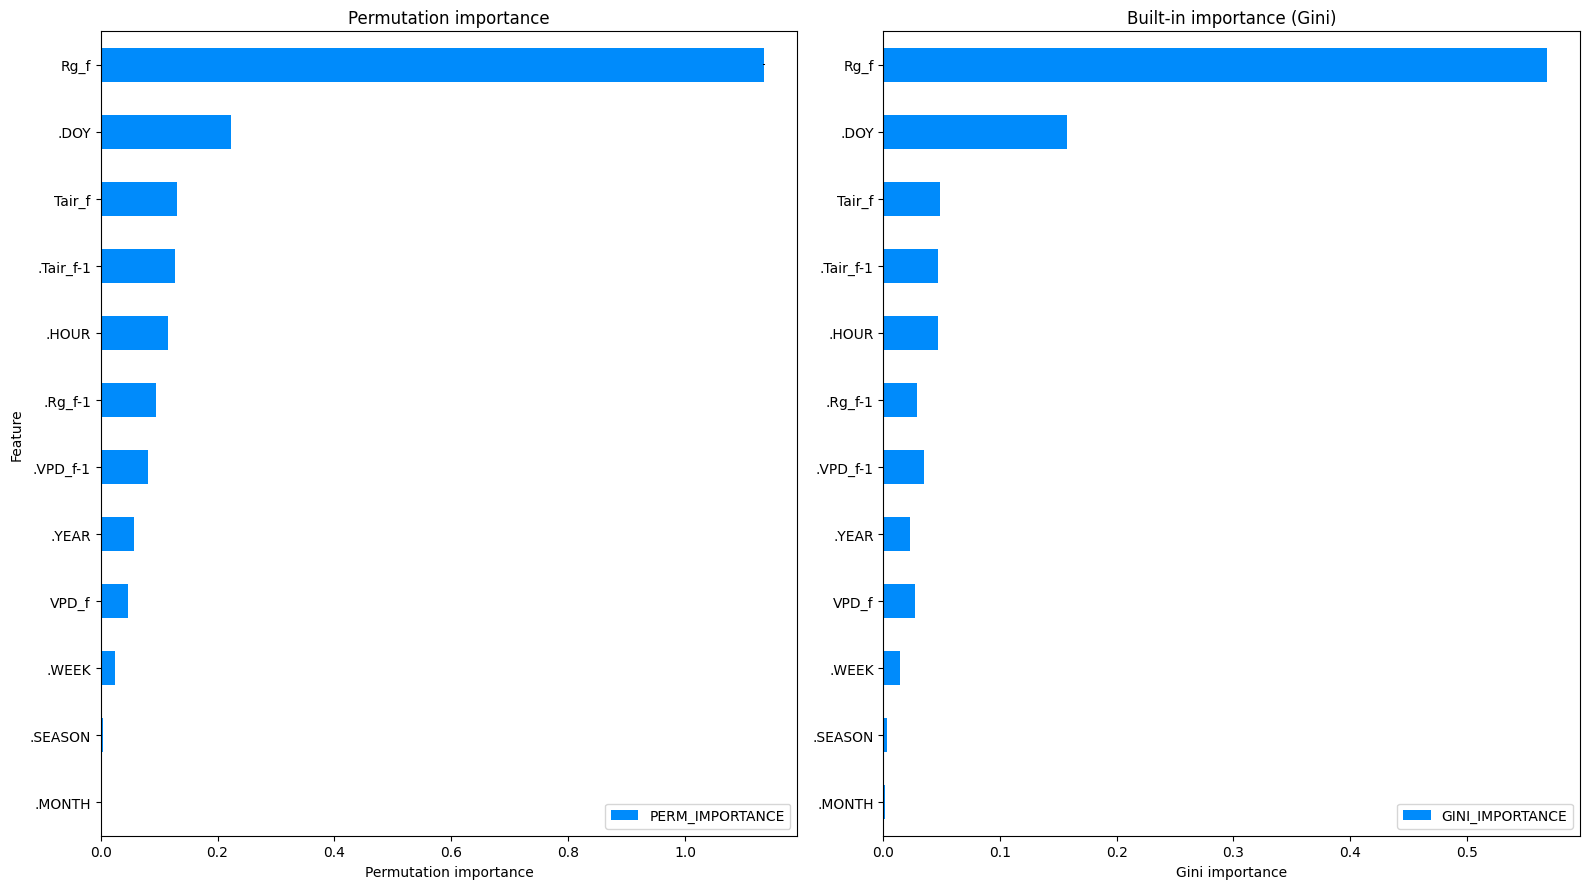

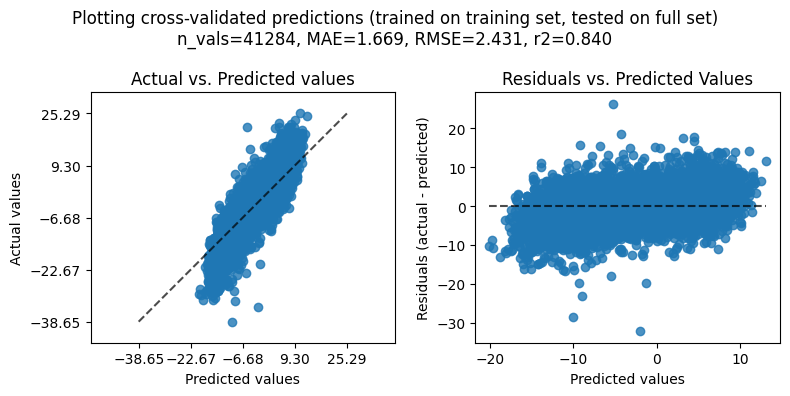

Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR'] (ONLY FALLBACK)


In [35]:
rfts.fillgaps(showplot_scores=True, showplot_importance=True, verbose=1)

</br>

## Report

In [36]:
rfts.report()

(report gap-filling)  GAP-FILLING RESULTS
(report gap-filling)    First timestamp:  2013-01-01 00:15:00
(report gap-filling)    Last timestamp:  2022-12-31 23:45:00
(report gap-filling)    Potential number of values: 175296 values)
(report gap-filling) 
(report gap-filling)    TARGET
(report gap-filling)    - target column (observed):  NEE_CUT_REF_orig
(report gap-filling)    - missing records (observed):  134012 (cross-check from flag: 134012)
(report gap-filling)    - target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (175296 values)
(report gap-filling)    - missing records (gap-filled):  0
(report gap-filling)    - gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
(report gap-filling)        - flag 0 ... observed targets (41284 values)
(report gap-filling)        - flag 1 ... targets gap-filled with high-quality, all features available (134011 values)
(report gap-filling)        - flag 2 ... targets gap-filled with fallback (1 values)
(report gap-filling) 
(report gap-filling)

In [37]:
rfts.scores

{'mae': 1.6690590220070385,
 'medae': 1.1377573266757317,
 'mse': 5.910763742667024,
 'rmse': 2.431206232031134,
 'mape': 2.495977215692848,
 'maxe': 32.2733827205473,
 'r2': 0.84038689727522}

In [38]:
rfts.feature_importances['importances']

,PERM_IMPORTANCE,PERM_SD,GINI_IMPORTANCE
.MONTH,0.001385,0.000030,0.001312
.SEASON,0.004650,0.000283,0.002708
.WEEK,0.025078,0.000319,0.014638
VPD_f,0.047447,0.000549,0.026736
.YEAR,0.056930,0.000615,0.022559
.VPD_f-1,0.081104,0.000593,0.034921
.Rg_f-1,0.094752,0.000941,0.029122
.HOUR,0.115873,0.001697,0.046973
.Tair_f-1,0.127457,0.001275,0.046807
Tair_f,0.130287,0.001883,0.048239


</br>

## Result

In [39]:
rfts.gapfilling_df

,.PREDICTIONS,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE
TIMESTAMP_MIDDLE,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,1.096830,1.096830,1.096830
2013-01-01 00:45:00,0.887347,NaN,0.887347,1.0,0.887347,1.096830,1.984176
2013-01-01 01:15:00,0.888477,NaN,0.888477,1.0,0.888477,1.028185,2.872653
2013-01-01 01:45:00,0.888477,0.537565,NaN,0.0,0.537565,1.028185,3.410218
2013-01-01 02:15:00,0.129364,NaN,0.129364,1.0,0.129364,1.014407,3.539582
...,...,...,...,...,...,...,...
2022-12-31 21:45:00,3.022467,NaN,3.022467,1.0,3.022467,3.128009,-65910.674020
2022-12-31 22:15:00,3.256826,3.517950,NaN,0.0,3.517950,3.159151,-65907.156070
2022-12-31 22:45:00,2.673302,NaN,2.673302,1.0,2.673302,3.159151,-65904.482768


In [40]:
gapfilled = rfts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1.096830
2013-01-01 00:45:00    0.887347
2013-01-01 01:15:00    0.888477
2013-01-01 01:45:00    0.537565
2013-01-01 02:15:00    0.129364
                         ...   
2022-12-31 21:45:00    3.022467
2022-12-31 22:15:00    3.517950
2022-12-31 22:45:00    2.673302
2022-12-31 23:15:00    4.513958
2022-12-31 23:45:00    4.554745
Freq: 30T, Name: NEE_CUT_REF_orig_gfRF, Length: 175296, dtype: float64

</br>

## Plot

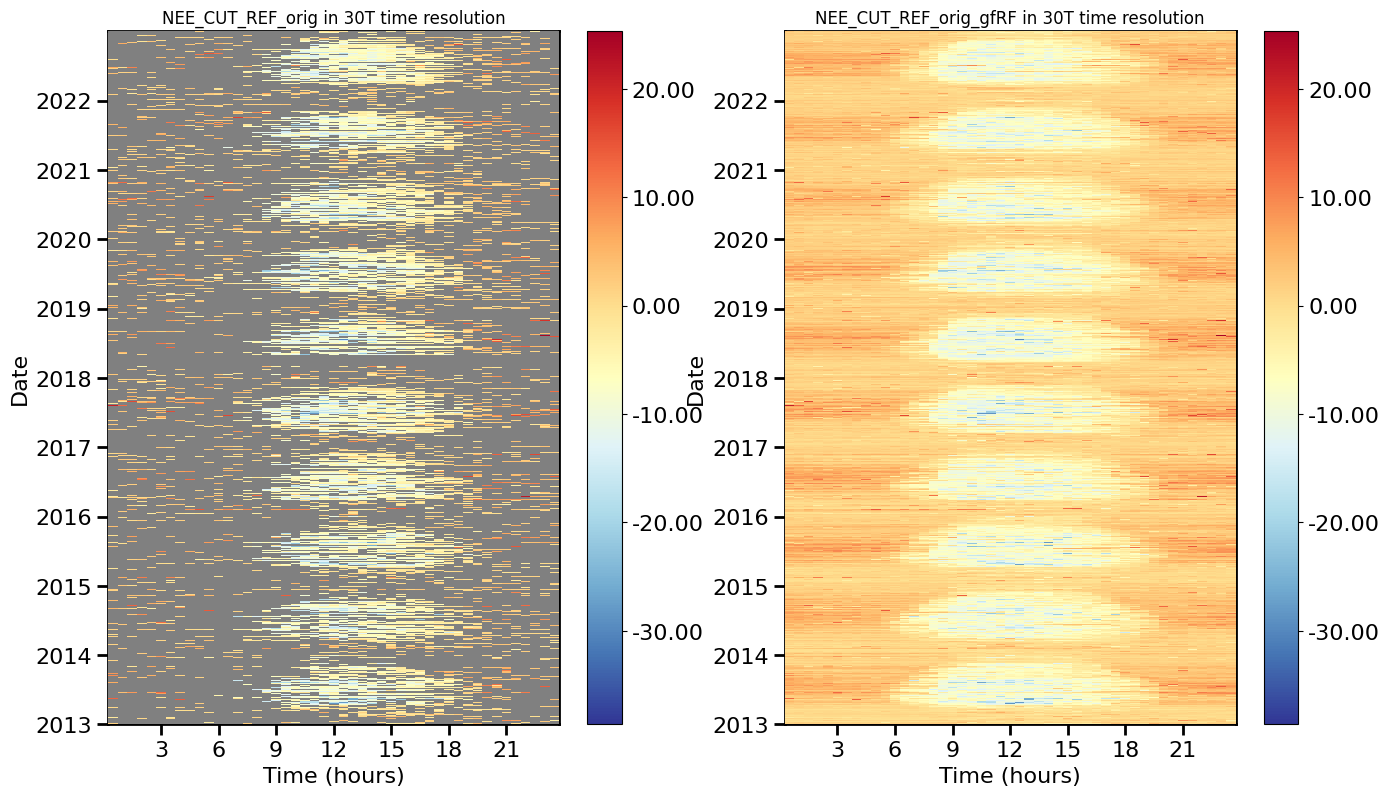

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

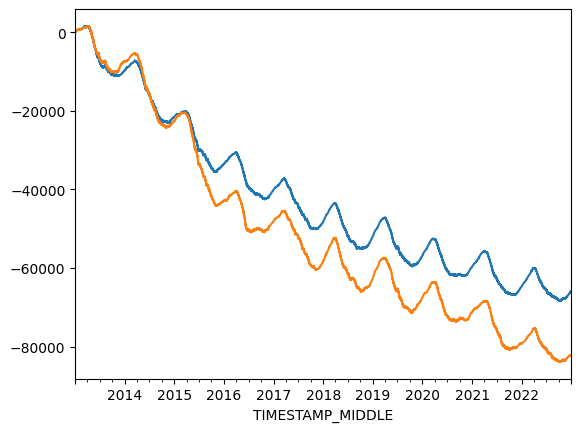

In [43]:
gapfilled.cumsum().plot(label="model HQ, all gaps filled with model");
source_df['NEE_CUT_REF_f'].cumsum().plot(label="model HQ, all gaps filled with model");

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [44]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-09-09 00:38:32
